In [1]:
import pandas as pd
from datetime import datetime, date

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")
from math import cos, asin, sqrt, pi


import seaborn as sns
%matplotlib inline

from geopy.geocoders import Nominatim

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint as sp_randint
from scipy.stats import uniform


In [2]:
df = pd.read_csv('Train.csv')
df.dtypes
full_data = df.sample(frac=.50, random_state=2)
print(full_data.shape)
df_test = pd.read_csv('Test.csv')
df_test = df_test.sample(frac=.50, random_state=2)
print(df_test.shape)


(41962, 8)
(17812, 7)


In [3]:
full_data['Timestamp'] = pd.to_datetime(full_data.Timestamp, infer_datetime_format=True)
full_data = full_data.set_index('Timestamp')


In [4]:
full_data['Hour'] = full_data.index.hour
hours = full_data.Hour.unique()
hours

array([23, 20, 21,  5,  0,  4, 22,  1,  2,  3])

In [5]:
full_data['Is_Weekend'] = full_data.index.weekday
full_data['Is_Weekday'] = full_data.index.weekday
full_data['Is_Weekend'] = full_data.Is_Weekend.replace([1,2,3,4], 0)
full_data['Is_Weekend'] = full_data.Is_Weekend.replace([5,6], 1)
full_data['Is_Weekday'] = full_data.Is_Weekday.replace([0,1,2,3,4], 1)
full_data['Is_Weekday'] = full_data.Is_Weekday.replace([5,6], 0)

In [6]:
full_data['November'] = full_data.index.month
full_data['December'] = full_data.index.month
full_data['November'] = full_data.November.replace({11:1, 12:0})
full_data['December'] = full_data.December.replace({11:0, 12: 1})

In [7]:
full_data['Night'] = full_data.Hour
full_data['Morning'] = full_data.Hour
full_data['Night'] = full_data.Night.replace([0,1,2,3,4,5], 0)
full_data['Night'] = full_data.Night.replace([20,21,22,23], 1)
full_data['Morning'] = full_data.Morning.replace([0,1,2,3,4,5], 1)
full_data['Morning'] = full_data.Morning.replace([20,21,22,23], 0)
full_data.head()

,ID,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Hour,Is_Weekend,Is_Weekday,November,December,Night,Morning
Timestamp,,,,,,,,,,,,,,
2019-12-16 23:41:32,LPXROEDH,2.905,36.786,3.031,36.720,20593,1367,23,0,1,0,1,1,0
2019-12-08 20:17:01,0HTJYDT0,2.997,36.736,2.946,36.745,9574,843,20,1,0,0,1,1,0
2019-12-18 21:38:25,I6HIICIW,3.041,36.741,3.031,36.720,3519,603,21,0,1,0,1,1,0
2019-12-12 05:20:19,FK0TSQ9I,2.988,36.756,3.207,36.698,26123,1621,5,0,1,0,1,0,1
2019-12-07 00:11:33,O6CX8E8Z,3.224,36.726,3.084,36.705,16342,1164,0,1,0,0,1,0,1


In [8]:
origins = full_data[['Origin_lat', 'Origin_lon']]
dests = full_data[['Destination_lat', 'Destination_lon']]

origins_normalized = MinMaxScaler().fit_transform(origins) 
origins_normalized = pd.DataFrame(origins_normalized, columns=origins.columns)
dests_normalized = MinMaxScaler().fit_transform(dests)
dests_normalized = pd.DataFrame(dests_normalized, columns=dests.columns)

def evaluate_k_kmeans_inertia(k, data):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(data)
    return estimator_kmeans.inertia_
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results1_k = {}
results2_k = {}
for k in range_k:
    results1_k[k] = evaluate_k_kmeans_inertia(k, origins_normalized)
    results2_k[k] = evaluate_k_kmeans_inertia(k, dests_normalized)


running Kmeans with k=2
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=25
running Kmeans with k=30
running Kmeans with k=30


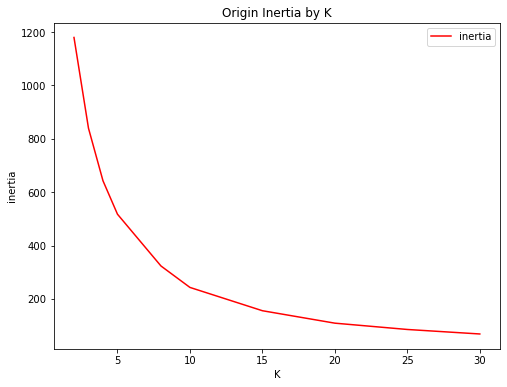

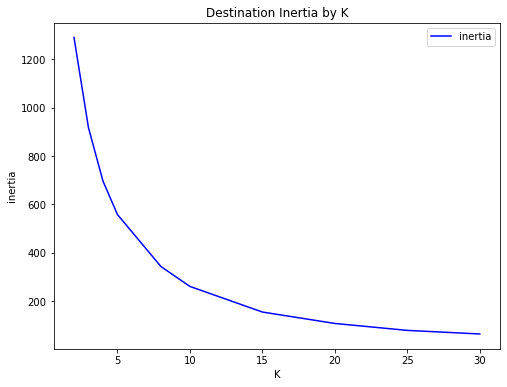

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results1_k.items()],
    [c[1] for c in results1_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Origin Inertia by K")
ax.legend()

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1 = sns.lineplot(
    [c[0] for c in results2_k.items()],
    [c[1] for c in results2_k.items()], label="inertia", color="blue")
ax1.set_xlabel("K")
ax1.set_ylabel("inertia")
ax1.set_title("Destination Inertia by K")
ax1.legend()

In [10]:
model_KO = KMeans(random_state=42, n_clusters=20)
model_KO.fit(origins_normalized)
model_KO.predict(origins_normalized)

model_KD = KMeans(random_state=42, n_clusters=20)
model_KD.fit(dests_normalized)
model_KD.predict(dests_normalized)

array([6, 0, 6, ..., 7, 4, 1], dtype=int32)

In [11]:
full_data['Cluster_ID_Origin'] = model_KO.labels_
full_data['Cluster_ID_Destination'] = model_KD.labels_
full_data.head()

,ID,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,Hour,Is_Weekend,Is_Weekday,November,December,Night,Morning,Cluster_ID_Origin,Cluster_ID_Destination
Timestamp,,,,,,,,,,,,,,,,
2019-12-16 23:41:32,LPXROEDH,2.905,36.786,3.031,36.720,20593,1367,23,0,1,0,1,1,0,16,6
2019-12-08 20:17:01,0HTJYDT0,2.997,36.736,2.946,36.745,9574,843,20,1,0,0,1,1,0,13,0
2019-12-18 21:38:25,I6HIICIW,3.041,36.741,3.031,36.720,3519,603,21,0,1,0,1,1,0,0,6
2019-12-12 05:20:19,FK0TSQ9I,2.988,36.756,3.207,36.698,26123,1621,5,0,1,0,1,0,1,12,1
2019-12-07 00:11:33,O6CX8E8Z,3.224,36.726,3.084,36.705,16342,1164,0,1,0,0,1,0,1,7,11


In [12]:
print('Origin silhouette: ', silhouette_score(origins_normalized, model_KO.labels_))
print('Origin calinski: ', calinski_harabasz_score(origins_normalized, model_KO.labels_))

print('Destination silhouette: ', silhouette_score(dests_normalized, model_KD.labels_))
print('Destination calinski: ', calinski_harabasz_score(dests_normalized, model_KD.labels_))



Origin silhouette:  0.4106876832804969
Origin calinski:  38550.964547464806
Destination silhouette:  0.4547524115621325
Destination calinski:  45106.12595107623


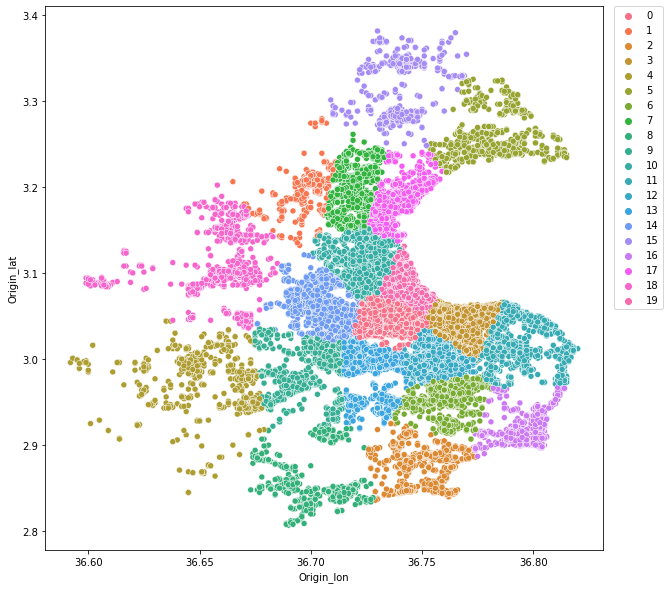

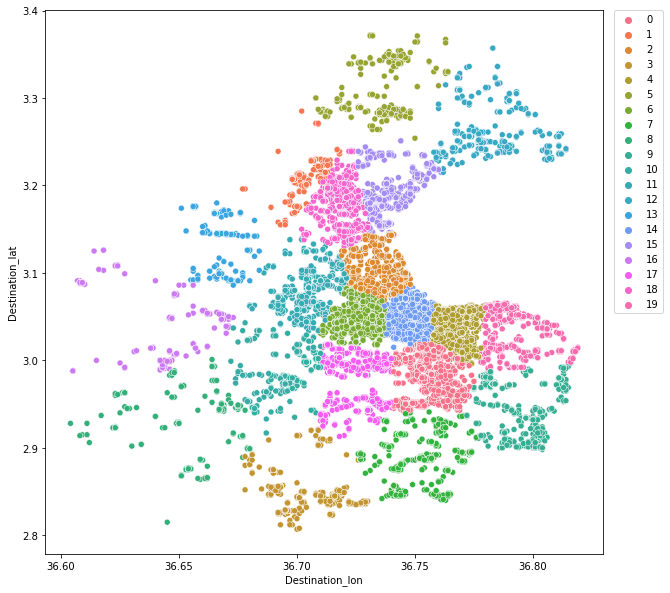

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=full_data, x='Origin_lon', y='Origin_lat', hue='Cluster_ID_Origin', palette=sns.color_palette("husl", 20))
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig, ax1 = plt.subplots(figsize=(10,10))
ax1 = sns.scatterplot(data=full_data, x='Destination_lon', y='Destination_lat', hue='Cluster_ID_Destination', palette=sns.color_palette("husl", 20))
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Text(0.5, 1.0, 'Destinations')

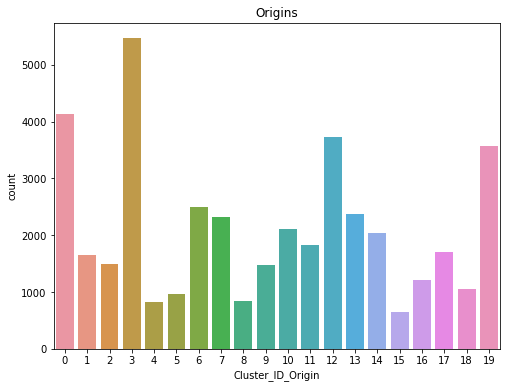

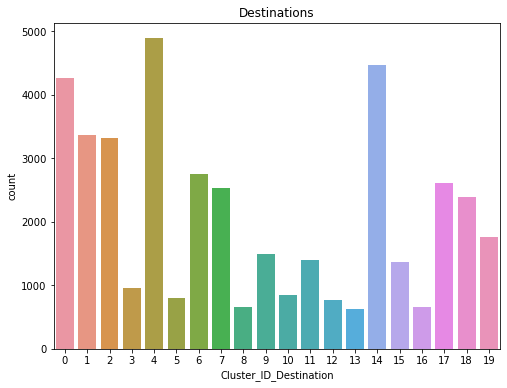

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(data=full_data, x='Cluster_ID_Origin')
ax.set_title('Origins')

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1 = sns.countplot(data=full_data, x='Cluster_ID_Destination')
ax1.set_title('Destinations')

Text(0.5, 1.0, 'Destinations')

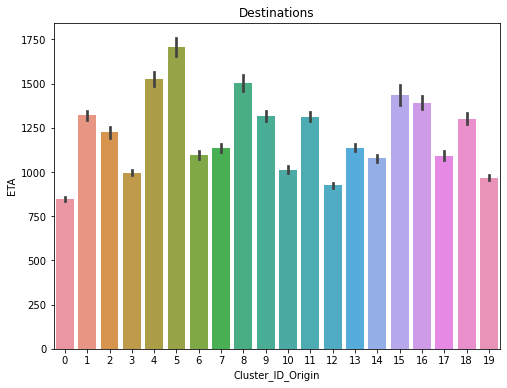

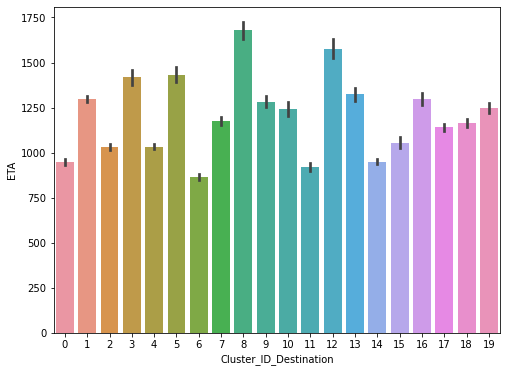

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(data=full_data, x='Cluster_ID_Origin', y='ETA')
ax.set_title('Origins')

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1 = sns.barplot(data=full_data, x='Cluster_ID_Destination', y='ETA')
ax.set_title('Destinations')

<AxesSubplot:>

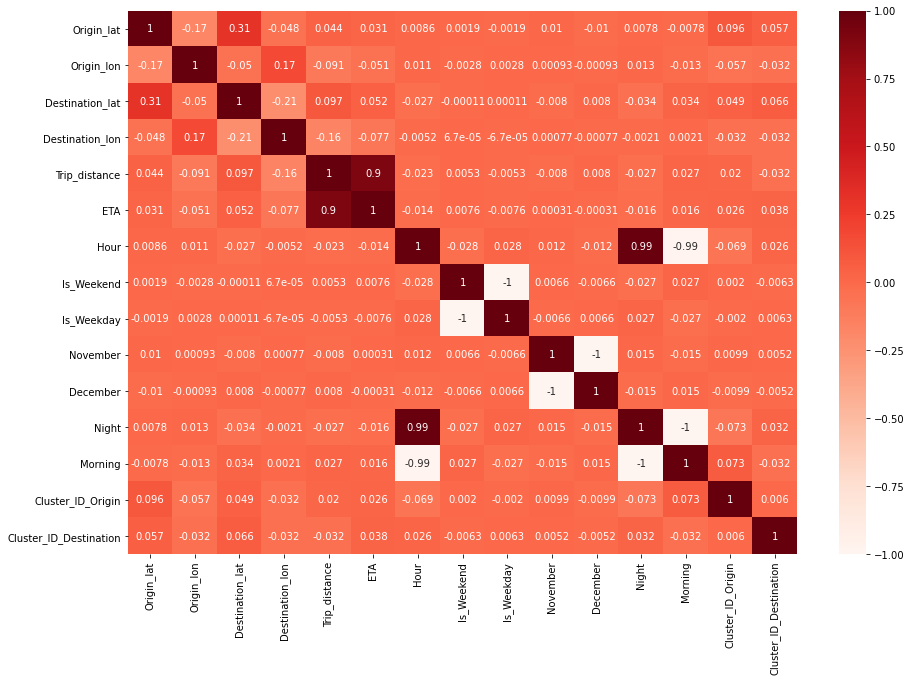

In [16]:
plt.figure(figsize=(15,10))
cor = full_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [17]:
full_data = pd.get_dummies(data=full_data, columns=['Cluster_ID_Origin', 'Cluster_ID_Destination'], drop_first=False)

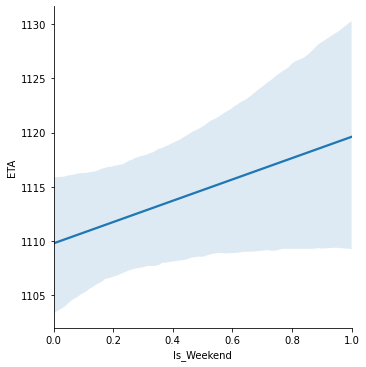

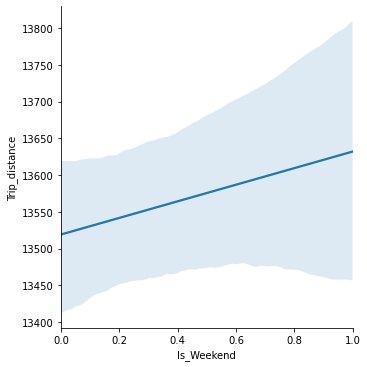

In [18]:
sns.lmplot(data=full_data, x='Is_Weekend', y='ETA', scatter = False)
sns.lmplot(data=full_data, x='Is_Weekend', y='Trip_distance', scatter = False)

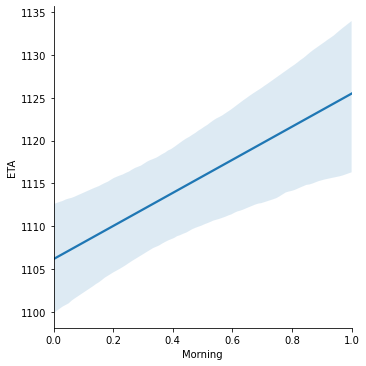

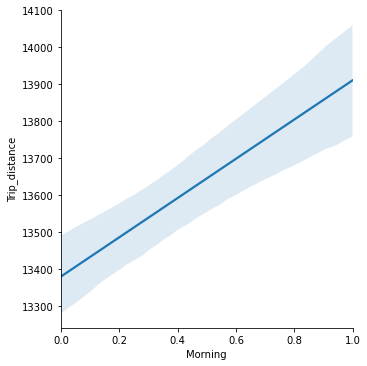

In [19]:
sns.lmplot(data=full_data, x='Morning', y='ETA', scatter=False)
sns.lmplot(data=full_data, x='Morning', y='Trip_distance', scatter = False)

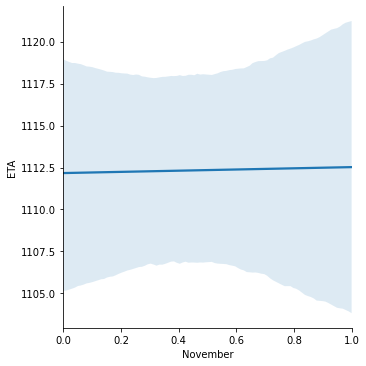

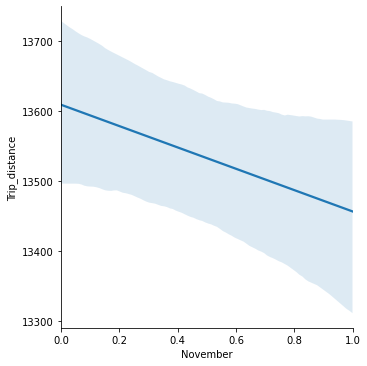

In [20]:
sns.lmplot(data=full_data, x='November', y='ETA', scatter = False)
sns.lmplot(data=full_data, x='November', y='Trip_distance', scatter = False)

In [21]:
train = full_data.drop(['Hour', 'ID', 'Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon'], axis=1)

In [22]:
target = 'ETA'
X = train.drop(target, axis=1)
X_cols = X.columns
y = train[target]
X.columns

Index(['Trip_distance', 'Is_Weekend', 'Is_Weekday', 'November', 'December',
       'Night', 'Morning', 'Cluster_ID_Origin_0', 'Cluster_ID_Origin_1',
       'Cluster_ID_Origin_2', 'Cluster_ID_Origin_3', 'Cluster_ID_Origin_4',
       'Cluster_ID_Origin_5', 'Cluster_ID_Origin_6', 'Cluster_ID_Origin_7',
       'Cluster_ID_Origin_8', 'Cluster_ID_Origin_9', 'Cluster_ID_Origin_10',
       'Cluster_ID_Origin_11', 'Cluster_ID_Origin_12', 'Cluster_ID_Origin_13',
       'Cluster_ID_Origin_14', 'Cluster_ID_Origin_15', 'Cluster_ID_Origin_16',
       'Cluster_ID_Origin_17', 'Cluster_ID_Origin_18', 'Cluster_ID_Origin_19',
       'Cluster_ID_Destination_0', 'Cluster_ID_Destination_1',
       'Cluster_ID_Destination_2', 'Cluster_ID_Destination_3',
       'Cluster_ID_Destination_4', 'Cluster_ID_Destination_5',
       'Cluster_ID_Destination_6', 'Cluster_ID_Destination_7',
       'Cluster_ID_Destination_8', 'Cluster_ID_Destination_9',
       'Cluster_ID_Destination_10', 'Cluster_ID_Destination_11',
     

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [24]:
model_LR = LinearRegression()

params = {'fit_intercept': [True, False],
          'normalize': [True, False],
          'copy_X': [True, False],
          'positive': [True, False]}

random_search = RandomizedSearchCV(
    estimator=model_LR, 
    param_distributions=params,
   scoring="r2", n_jobs=-1, 
    n_iter=50)


def evaluate_model(estimator, X, y):  
    cv_results = cross_validate(estimator, X, y,  
                     scoring="r2",
                          n_jobs=-1, cv=5,
                     return_train_score=True)
    return pd.DataFrame(cv_results).mean().to_dict()


In [25]:
random_search.fit(X_train, y_train)
random_search.best_score_

0.8429995431127102

In [26]:
RESULTS = {}
RESULTS['Linear_Regression_One'] = evaluate_model(
    random_search.best_estimator_,
    X_test, y_test
)
pd.DataFrame(RESULTS).T

,fit_time,score_time,test_score,train_score
Linear_Regression_One,0.066742,0.006118,0.83943,0.841608


In [27]:
model_R = Ridge()


params_R = {'alpha': uniform(loc=.1, scale=10),
           'fit_intercept': [True, False]
}
random_ridge_search = RandomizedSearchCV(estimator=model_R, 
                                         param_distributions=params_R,
                                         scoring="r2", n_jobs=-1, 
                                         n_iter=50)


In [28]:
random_ridge_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=Ridge(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fabca946d00>,
                                        'fit_intercept': [True, False]},
                   scoring='r2')

In [29]:
RESULTS['RIDGE_ONE'] = evaluate_model(random_ridge_search.best_estimator_, X_test, y_test)
pd.DataFrame(RESULTS).T

,fit_time,score_time,test_score,train_score
Linear_Regression_One,0.066742,0.006118,0.839430,0.841608
RIDGE_ONE,0.024000,0.007160,0.839449,0.841575


In [30]:
forest = RandomForestRegressor(n_estimators=100)
params_forest = {'bootstrap': [True, False],
                 'max_features': ['auto', 'sqrt', 'log2']}
random_search_forest = RandomizedSearchCV(estimator=forest, param_distributions=params_forest, scoring='r2', n_jobs=-1, n_iter=50)


In [31]:
random_search_forest.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2']},
                   scoring='r2')

In [32]:
RESULTS['Random_Forest_Regressor'] = evaluate_model(random_search_forest.best_estimator_, X_test, y_test)
pd.DataFrame(RESULTS).T

,fit_time,score_time,test_score,train_score
Linear_Regression_One,0.066742,0.006118,0.839430,0.841608
RIDGE_ONE,0.024000,0.007160,0.839449,0.841575
Random_Forest_Regressor,5.425774,0.078136,0.858007,0.979631
